In [114]:
import numpy as np
import matplotlib

# Embed fonts into PDF/PS files
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors

import scipy.integrate

# Progress bars
import tqdm.notebook

# Make deep copies
import copy

# For 3d plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial']})

# Define parameters

In [3]:
# Data taken from Arenz et al. 2008, Fig. 1G
arenz_data = np.array([[9.92689248942709, 4.122790122862343],
                        [20.021881428338318, 8.354626263598984],
                        [29.872911166215914, 13.083689775915978]])

np.mean(arenz_data[:,1]/arenz_data[:,0])

0.4235228205522715

In [30]:
## Physiological parameters

# mvn head sensitvity in the light: 0.38 sp/s / deg/s -- Beraneck & Cullen 2007
# => v_0 ~= 2.7
# => w_pc_mvn ~= 1.77 (Beraneck & Cullen report spont. ~60 sp/s)

# initial gain ~- 0.4 in mice (Katoh et al. 2015, Boyden & Raymond 2003)
# gain = k_eye * (v*k_MF - w_pc_mvn*w*k_PF)
# => k_eye = 1.06

# average learning in one day ~20-40% (Kimpo et al. 2014, Boyden & Raymond 2003)
# delta w ~= delta g/g_0 * v_0*k_MF / w_pc_mvn*k_PF
# delta w ~= 0.15 => delta g/g_0 ~= 0.3 on day 1
# w_infinity ~= k_LTD * k_PF * peak velocity / 2 (if delta CF = sin(wt))
# => k_LTD = 0.07 => delta w ~= 0.15

# memory retention ~75% after 24 hr calculated from Boyden & Raymond 2003

params = {
    'mf_0': 55, # Lasker et al. 2008
    'pf_0': 14, # Arenz et al. 2008 -- assume each MF EPSC evokes a GC spike
    'cf_0': 1,
    'mf_sensitivity': 0.14, # Lasker et al. 2008
    'pf_sensitivity': 0.42, # Arenz et al. 2008 (See above)
    'w_i': 1,
    'pc_0':50, # Katoh et al. 2015
    'mvn_0': 12, # Nelson et al. 2003   
    'w_pc_mvn': 1.77,
    'k_eye': 1.06,
    'k_v':1.55e-3, # to get 75% retention
    'tau_f': 0.017, # fast average
    'tau_mvn': 1, # tau_f,v: average of activity being integrated at MVN
    'tau_learn': 0.15, # Boyden & Raymond 2003
    'tau_post': 3, # consistent with 4 hour window, Attwell et al. 2002
    'k_LTD': 0.07,
}
params['k_LTP'] = params['w_i']/params['pf_0'] + params['k_LTD']*params['cf_0']

## Behavioral parameters

# Kimpo et al. 2014, Nguyen-Vu et al. 2013, Boyden & Raymond 2003
stim_freq = 1 
peak_velocity_learn = 10 # deg/s

# We use a higher peak velocity during the post-training period
# so that the blow-up can be seen for the Hebbian rule
# (see Supplementary materials S.1)
peak_velocity_post = 30

# Define function for head velocity
head_learn = lambda t: peak_velocity_learn*np.sin(2*np.pi*stim_freq*3600*t)
head_post_input = lambda t: peak_velocity_post*np.sin(2*np.pi*stim_freq*3600*t) # w/post-training input
head_post_no_input = lambda t: 0 # w/o post-training input

# Define function for retinal slip
rs_learn = lambda t: np.sin(2*np.pi*stim_freq*3600*t)
rs_post = lambda t: 0

# ODE solver code

We use built-in ODE solvers (implemented by `scipy.integrate`) to perform simulations. The ODE solvers take functions that have the current time value (`t`) and the state (`y`) at that time as arguments and return a vector of the same size as `y` that gives the instantaneous derivative. We also provide a function for the Jacobian, which takes the same arguments and returns the Jacobian matrix.

We solve a system of 5 variables, with `y[0]` defining $w$, `y[1]` $v$, `y[2]` the exponential average $\langle\text{MF}(\text{PC} - \text{PC}_0)\rangle_{\tau_{f,v}}$, `y[3]` $\langle\text{PF}\rangle_{\tau_f}$, and `y[4]` $\langle\text{PF}\cdot\text{CF}\rangle_{\tau_f}$.

In [41]:
# Function to pass to ODE solver
def heterosynaptic(t, y, head, retinal_slip, learn, params):
    '''
    head: a function taking a time argument that returns the head velocity
    retinal_slip: a function taking a time argument that returns the retinal slip velocity
    learn: set to True if in the training period, False if in the post-training period
    params: list containing the physiological parameters
    
    '''
    delta_mf = params['mf_sensitivity']*head(t)
    delta_pf = params['pf_sensitivity']*head(t)
    delta_cf = retinal_slip(t)
    
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    pf = params['pf_0'] + delta_pf
    cf = params['cf_0'] + delta_cf
    
    w = y[0]
    v = y[1]
    
    delta_pc = (w - params['w_i'])*pf
    pc = delta_pc + params['pc_0']
    
    dydt = np.zeros(5)
    dydt[0] = 1/tau_w * (-y[0] + params['k_LTP']*y[3] - params['k_LTD']*y[4])
    dydt[1] = params['k_v']*(-y[2])
    dydt[2] = 1/params['tau_mvn'] * (-y[2] + mf*delta_pc)
    dydt[3] = 1/params['tau_f'] * (-y[3] + pf)
    dydt[4] = 1/params['tau_f'] * (-y[4] + pf*cf)
    
    return dydt

# Jacobian 
def heteroJac(t, y, head, retinal_slip, learn, params):
    delta_mf = params['mf_sensitivity']*head(t)
    
    if learn:
        tau_w = params['tau_learn']
    else:
        tau_w = params['tau_post']
    mf = params['mf_0'] + delta_mf
    
    jac = -1/params['tau_f']*np.eye(5)
    jac[0,:] = 1/tau_w*np.array([-1, 0, 0, params['k_LTP'], -params['k_LTD']])
    jac[1,:] = params['k_v']*np.array([0, -1, 0, 0, 0])
    jac[2,:] = 1/params['tau_mvn']*np.array([-mf, 0, -1, 0, 0])
    
    return jac

# Simulation for Figure 1c

In [6]:
## Time steps for plotting (ODE solver uses variable time steps)

dt_learn = 1/3600 # h (= 1 s)
dt_post = 60/3600 # h (= 1 min)

In [20]:
T_learn = 0.5 # h

T_post = 24 - T_learn # s

t_learn = np.linspace(0, T_learn, int(T_learn/dt_learn))
t_post = np.linspace(0, T_post, int(T_post/dt_post))

# Initial condition
# v(t=0) = 2.7 was calculated based on parameters above
y_0 = np.array([params['w_i'], 2.7, 0, params['pf_0'], params['pf_0']*params['cf_0']])

# Solution during the training period
sol_learn = scipy.integrate.solve_ivp(lambda t,y: heterosynaptic(t,y, head_learn, rs_learn, True, params), [0, T_learn], y_0, 
                                  jac=lambda t,y: heteroJac(t,y,head_learn, rs_learn,True,params), method='Radau', dense_output=True)

# Solution during the post-training period w/o input
sol_no_input_post = scipy.integrate.solve_ivp(lambda t,y: heterosynaptic(t,y, head_post_no_input, rs_post, False, params), [0, T_post],sol_learn.sol(T_learn),
                                  jac=lambda t,y: heteroJac(t,y,head_post_no_input, rs_post, False, params), method='Radau',dense_output=True)

# Solution during the post-training period w/input
sol_input_post = scipy.integrate.solve_ivp(lambda t,y: heterosynaptic(t,y, head_post_input, rs_post, False, params), [0,T_post],sol_learn.sol(T_learn),
                                 jac=lambda t,y: heteroJac(t,y,head_post_input, rs_post, False, params), method='Radau',max_step=1/3600*0.5, dense_output=True)


# Concatenate solution vectors over time

y_learn = sol_learn.sol(t_learn)

y_no_input = np.hstack((y_learn, sol_no_input_post.sol(t_post)))
y_input = np.hstack((y_learn, sol_input_post.sol(t_post)))

t_sol = np.concatenate((t_learn, T_learn+t_post))

In [21]:
# Calculate the gain over time

gain_no_input = params['k_eye']*(y_no_input[1,:]*params['mf_sensitivity']
                        - (y_no_input[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

gain_input = params['k_eye']*(y_input[1,:]*params['mf_sensitivity']
                        - (y_input[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

# gain achieved during training
gain_learn = params['k_eye']*(y_learn[1,:]*params['mf_sensitivity'] 
                              - (y_learn[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

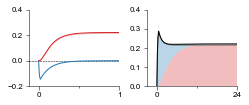

In [23]:
plt.figure(figsize=(3.5,1.5))
ax = plt.subplot(1,2,1)
plt.plot([-3, 24], [0,0], c='k', ls='--', lw=0.5)
plt.plot(t_sol, y_no_input[0,:]-1,lw=1)
plt.plot(t_sol, (y_no_input[1,:]-y_no_input[1,0])/y_no_input[1,0], c='C3',lw=1, alpha=0.3)
plt.plot(t_sol, (y_input[1,:]-y_input[1,0])/y_input[1,0], c='C3',lw=1)

plt.ylim([-0.2, 0.4])
plt.xlim([-3, 24])

ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(1,2,2)

plt.plot(t_sol, gain_no_input/gain_no_input[0]-1, c=(0.5,0.5,0.5),lw=1)
plt.plot(t_sol, gain_input/gain_input[0]-1, c='k',lw=1)
plt.fill_between(t_sol, 0, params['k_eye']*params['mf_sensitivity']*y_input[1,:]/gain_input[0]-1, facecolor='C3',alpha=0.3)
plt.fill_between(t_sol, params['k_eye']*params['mf_sensitivity']*y_input[1,:]/gain_input[0]-1,
                 gain_input/gain_input[0]-1, facecolor='C0',alpha=0.3)

plt.ylim([0, 0.4])
plt.xlim([-3, 24])
ax.set_xticks([0, 24])
ax.set_xticks([12], minor=True)
ax.set_xticklabels([0, 24])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Simulation for Figure 2

In [39]:
def simulateTraining(y0, T_learn, T_post, head_learn, head_post, rs_learn, rs_post, params, 
                     dt_learn = 1/3600, dt_post = 60/3600, returnSeparate=False):
    '''Simulate a training and post-training period. 
    y0: initial condition
    T_learn: time (h) of training period
    T_post: time (h) of post-training period
    head_learn: function taking one argument (t) and returning head velocity at t during the training period
    head_post: function taking one argument (t) and returning head velocity at t during the post-training period
    rs_learn: function taking one argument (t) and returning retinal slip velocity at t during the training period
    rs_post: function taking one argument (t) and returning retinal slip velocity at t during the post-training period
    params: physiological parameters list
    dt_learn: training time step (for plotting)
    dt_post: post-training time step (for plotting)
    returnSeparate: if True, returns separate variables for the training and post-training periods
    '''
    
    t_learn = np.arange(0, int(T_learn/dt_learn))*dt_learn
    t_post = np.arange(0, int(T_post/dt_post))*dt_post

    sol_learn = scipy.integrate.solve_ivp(lambda t,y: heterosynaptic(t,y, head_learn, rs_learn, True, params), [0, T_learn], y0, 
                                      jac=lambda t,y: heteroJac(t,y,head_learn, rs_learn,True,params), method='Radau', dense_output=True)

    sol_post = scipy.integrate.solve_ivp(lambda t,y: heterosynaptic(t,y, head_post, rs_post, False, params), [0,T_post],sol_learn.sol(T_learn),
                                      jac=lambda t,y: heteroJac(t,y,head_post, rs_post, False, params), method='Radau', dense_output=True)


    if returnSeparate:
        return t_learn, sol_learn.sol(t_learn), t_post+T_learn, sol_post.sol(t_post)
    else:
        y_sol = np.hstack((sol_learn.sol(t_learn), sol_post.sol(t_post)))
        t_sol = np.concatenate((t_learn, T_learn+t_post))
        return t_sol, y_sol

In [26]:
y0 = np.array([params['w_i'], 2.7, 0, params['pf_0'], params['pf_0']*params['cf_0']]) 

In [112]:
perfect_gain_slope = params['w_pc_mvn']*params['pf_sensitivity']/params['mf_sensitivity']

In [113]:
# k_v expected from theory that would give rise to complete consolidation (assuming tau_mvn fast)

ideal_max_k_v = perfect_gain_slope/(params['tau_post']*params['mf_0']*params['pf_0'])

## Complete consolidation

In [35]:
# Make a copy of the parameters that can be altered separately
params_complete = copy.deepcopy(params)

In [36]:
params_complete['k_v'] = 0.8*ideal_max_k_v
params_complete['tau_mvn'] = params['tau_f'] # params['tau_mvn']

In [73]:
t_phase_learn_complete, y_phase_learn_complete, t_phase_post_complete, y_phase_post_complete = simulateTraining(y0, 0.5, 23.5, head_learn, head_post_no_input, 
                                                                                                    rs_learn, rs_post, params_complete, returnSeparate=True)


In [74]:
gain_phase_learn_complete = params['k_eye']*(y_phase_learn_complete[1,:]*params['mf_sensitivity']
                        - (y_phase_learn_complete[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

gain_phase_post_complete = params['k_eye']*(y_phase_post_complete[1,:]*params['mf_sensitivity']
                        - (y_phase_post_complete[0,:]-params['w_i'])*params['w_pc_mvn']*params['pf_sensitivity'])

In [48]:
ww, vv = np.meshgrid(np.array([-0.15, -0.09, -0.03, 0.03, 0.09, 0.15]), np.linspace(1.9, 3.5, 4))

In [50]:
dw = 1/params['tau_post']*(-ww)
dv = -params_complete['k_v']*(params['mf_0']*params['pf_0'])*ww

dw_norm = dw/np.sqrt(dw**2+dv**2)
dv_norm = dv/np.sqrt(dw**2+dv**2)

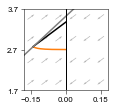

In [75]:
plt.figure(figsize=(1.5,1.5))
plt.quiver(ww, vv, dw_norm, dv_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

plt.plot(y_phase_learn_complete[0,:]-params['w_i'], y_phase_learn_complete[1,:], c='C1')
plt.plot(y_phase_post_complete[0,:]-params['w_i'], y_phase_post_complete[1,:], c='k')

# Plot perfect consolidation line
plt.plot([-0.18, 0.15], (np.array([-0.18,0.15])*params['w_pc_mvn']*params['pf_sensitivity'] + gain_phase_learn_complete[-1]/params['k_eye'])/params['mf_sensitivity'],
        c=(0.5, 0.5, 0.5))

# Plot attractor
plt.plot([0, 0], [1.7, 3.7], c='k', lw=1)

plt.ylim([1.7,3.7])
plt.xlim([-0.18, 0.18])

ax = plt.gca()
ax.set_xticks([-0.15, 0, 0.15])
ax.set_yticks([1.7, 2.7, 3.7]);

### Perturbation simulation

We simulated the effect of perturbations of random magnitude to the value of the early-learning weight, made regularly every 10 min (in simulation time) for a total of 10 hours (i.e., 60 perturbations). Parameters were as above for the post-training period. We then calculated the distribution of the final value of each of 250 sample paths. 

In [60]:
noise_len = 10/60 # h (= 10 min)
trial_len = 10 # h
num_perturbations = int(trial_len/noise_len) # total number of perturbations
trials = 250 # number of sample paths

noisy_input =  0.2*(np.random.rand(trials, num_perturbations)-0.5)

In [ ]:
noise_ends_complete = np.zeros((5,trials)) # value at the end of sample paths

t_noise = np.arange(0, noise_len/(dt_learn),1)*(dt_learn) # time vector between perturbations
t_noise_total = np.arange(0, trial_len/dt_learn, 1)*dt_learn # full time vector for a sample path
y_noise_complete = np.zeros((trials, 2, len(t_noise_total)))

y0 = np.array([params['w_i'], 2.7, 0, params['pf_0'], params['pf_0']*params['cf_0']]) 

for t in tqdm.notebook.trange(trials, desc='Trial'):
    y0_noisy = np.copy(y0)
    y_noise_temp = np.zeros((num_perturbations, 5, len(t_noise))) # temporary array for this trial
    
    for b in tqdm.notebook.trange(num_perturbations, desc='Perturbation', leave=False):
        y0_noisy[0] += noisy_input[t,b]
        sol_learn_noisy = scipy.integrate.solve_ivp(lambda t,y: heterosynaptic(t,y, head_post_input, rs_post, False, params_complete), [0, noise_len], y0_noisy, 
                                      jac=lambda t,y: heteroJac(t,y,head_post_input, rs_post,False,params_complete), method='Radau', dense_output=True)
        y_noise_temp[b,:,:] = sol_learn_noisy.sol(t_noise)
        y0_noisy = sol_learn_noisy.sol(noise_len)
    noise_ends_complete[:,t] = np.copy(y0_noisy)
    
    y_noise_complete[t,0,:] = np.concatenate((y_noise_temp[:,0,:]))
    y_noise_complete[t,1,:] = np.concatenate((y_noise_temp[:,1,:]))

In [139]:
# To plot the figure as in our manuscript, load our simulation results:

y_noise_complete_example = np.load('files/noisy_trials_example_complete.npy')
noise_ends_complete = np.load('files/noisy_trials_complete_ends.npy')

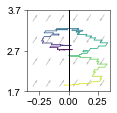

In [140]:
plt.figure(figsize=(1.5,1.5))
cmap = matplotlib.cm.get_cmap('viridis')

noise_total = num_perturbations
c_ = np.linspace(0,1,noise_total)
for i in range(noise_total):
    start_ = int(noise_len/dt_learn) * i
    end_ = int(noise_len/dt_learn) * (i+1)
    plt.plot(y_noise_complete_example[0,start_:end_+1]-1, y_noise_complete_example[1,start_:end_+1], c=cmap(c_[i]),lw=0.75)

ylims = [1.7, 3.7]
plt.plot([0,0],ylims,'k', lw=1)
xlims = [-0.36, 0.36] 
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

plt.ylim(ylims)
plt.xlim(xlims)

ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)
dv_phase = -params_complete['k_v']*(params['mf_0']*params['pf_0'])*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))


ax = plt.gca()

ax.set_yticks([1.7, 2.7, 3.7]);

In [586]:
gain_noise = params['k_eye']*(noise_ends[1,:]*params['mf_sensitivity']
                        - (noise_ends[0,:]-1)*params['w_pc_mvn']*params['pf_sensitivity'])

In [86]:
# Histogram bins for Fig. 2c, bottom

edges = np.arange(0,16,1)*0.42 - 0.45

In [87]:
complete_counts, complete_edges = np.histogram(noise_ends_complete[1,:], edges)

## Incomplete consolidation

In [70]:
params_incomplete = copy.deepcopy(params)

In [71]:
params_incomplete['k_v'] = 0.2*ideal_max_k_v
params_incomplete['tau_mvn'] = params['tau_f']

In [78]:
t_phase_learn_incomplete, y_phase_learn_incomplete, t_phase_post_incomplete, y_phase_post_incomplete = simulateTraining(y0, 0.5, 23.5, 
                                                                                              head_learn, head_post_no_input, 
                                                                                              rs_learn, rs_post, params_incomplete, returnSeparate=True)

In [79]:
gain_phase_learn_incomplete = params['k_eye']*(y_phase_learn_incomplete[1,:]*params['mf_sensitivity']
                        - (y_phase_learn_incomplete[0,:]-1)*params['w_pc_mvn']*params['pf_sensitivity'])

gain_phase_post_incomplete = params['k_eye']*(y_phase_post_incomplete[1,:]*params['mf_sensitivity']
                        - (y_phase_post_incomplete[0,:]-1)*params['w_pc_mvn']*params['pf_sensitivity'])

In [80]:
ww, vv = np.meshgrid(np.array([-0.15, -0.09, -0.03, 0.03, 0.09, 0.15]), np.linspace(1.9, 3.5, 4))

In [82]:
dw = 1/params['tau_post']*(-ww)
dv = -params_incomplete['k_v']*(params['mf_0']*params['pf_0'])*ww

dw_norm = dw/np.sqrt(dw**2+dv**2)
dv_norm = dv/np.sqrt(dw**2+dv**2)

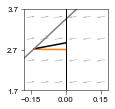

In [83]:
plt.figure(figsize=(1.5,1.5))
plt.quiver(ww, vv, dw_norm, dv_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))

plt.plot(y_phase_learn_incomplete[0,:]-1, y_phase_learn_incomplete[1,:], c='C1')
plt.plot(y_phase_post_incomplete[0,:]-1, y_phase_post_incomplete[1,:], c='k')

# Plot perfect consolidation line
plt.plot([-0.18, 0.15], (np.array([-0.18,0.15])*params['w_pc_mvn']*params['pf_sensitivity'] + gain_phase_learn_incomplete[-1]/params['k_eye'])/params['mf_sensitivity'],
        c=(0.5, 0.5, 0.5))

# Plot attractor
plt.plot([0, 0], [1.7, 3.7], c='k', lw=1)

plt.ylim([1.7,3.7])
plt.xlim([-0.18, 0.18])

ax = plt.gca()
ax.set_xticks([-0.15, 0, 0.15])
ax.set_yticks([1.7, 2.7, 3.7]);

In [ ]:
noise_ends_incomplete = np.zeros((5,trials)) # value at the end of sample paths

t_noise = np.arange(0, noise_len/(dt_learn),1)*(dt_learn) # time vector between perturbations
t_noise_total = np.arange(0, trial_len/dt_learn, 1)*dt_learn # full time vector for a sample path
y_noise_incomplete = np.zeros((trials, 2, len(t_noise_total)))

y0 = np.array([params['w_i'], 2.7, 0, params['pf_0'], params['pf_0']*params['cf_0']]) 

for t in tqdm.notebook.trange(trials, desc='Trial'):
    y0_noisy = np.copy(y0)
    y_noise_temp = np.zeros((num_perturbations, 5, len(t_noise))) # temporary array for this trial
    
    for b in tqdm.notebook.trange(num_perturbations, desc='Perturbation', leave=False):
        y0_noisy[0] += noisy_input[t,b]
        sol_learn_noisy = scipy.integrate.solve_ivp(lambda t,y: heterosynaptic(t,y, head_post_input, rs_post, False, params_incomplete), [0, noise_len], y0_noisy, 
                                      jac=lambda t,y: heteroJac(t,y,head_post_input, rs_post,False,params_incomplete), method='Radau', dense_output=True)
        y_noise_temp[b,:,:] = sol_learn_noisy.sol(t_noise)
        y0_noisy = sol_learn_noisy.sol(noise_len)
    noise_ends_incomplete[:,t] = np.copy(y0_noisy)
    
    y_noise_incomplete[t,0,:] = np.concatenate((y_noise_temp[:,0,:]))
    y_noise_incomplete[t,1,:] = np.concatenate((y_noise_temp[:,1,:]))

In [141]:
# To plot the figure as in our manuscript, load our simulation results:

y_noise_incomplete_example = np.load('files/noisy_trials_example_incomplete.npy')
noise_ends_incomplete = np.load('files/noisy_trials_incomplete_ends.npy')

In [88]:
incomplete_counts, incomplete_edges = np.histogram(noise_ends_incomplete[1,:], edges)

In [94]:
centers = edges[:-1] + 0.5*(edges[1:]-edges[:-1])

(0.0, 0.5)

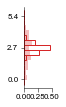

In [95]:
plt.figure(figsize=(0.5,1.5))
plt.barh(centers, complete_counts/np.sum(complete_counts), complete_edges[1]-complete_edges[0], alpha=0.3, facecolor='C3', lw=0.5)
plt.barh(centers, incomplete_counts/np.sum(incomplete_counts), complete_edges[1]-complete_edges[0], edgecolor='C3', facecolor='None')

# Plot lines at 1.7 and 3.7 (boundaries of axis in Fig. 2a,b)
# plt.plot([0, 0.5], [1.7, 1.7], c='k')
# plt.plot([0, 0.5], [3.7, 3.7], c='k')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0, 0.25, 0.5])
ax.set_yticks([0, 2.7, 5.4])
plt.xlim([0, 0.5])


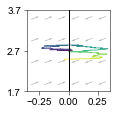

In [142]:
plt.figure(figsize=(1.5,1.5))
cmap = matplotlib.cm.get_cmap('viridis')

noise_total = num_perturbations
c_ = np.linspace(0,1,noise_total)
for i in range(noise_total):
    start_ = int(noise_len/dt_learn) * i
    end_ = int(noise_len/dt_learn) * (i+1)
    plt.plot(y_noise_incomplete_example[0,start_:end_+1]-1, y_noise_incomplete_example[1,start_:end_+1], c=cmap(c_[i]),lw=0.75)

ylims = [1.7, 3.7]
plt.plot([0,0],ylims,'k', lw=1)
xlims = [-0.36, 0.36]
ylimrange = ylims[1]-ylims[0]
xlimrange = xlims[1]-xlims[0]

plt.ylim(ylims)
plt.xlim(xlims)

ww_phase, vv_phase = np.meshgrid(xlims[0] + np.linspace(0.1,0.9,6)*xlimrange,ylims[0] + np.linspace(0.1,0.9,4)*ylimrange)
dw_phase = 1/params['tau_post']*(-ww_phase)
dv_phase = -params_incomplete['k_v']*(params['mf_0']*params['pf_0'])*ww_phase

dw_phase_norm = dw_phase/np.sqrt(dw_phase**2+dv_phase**2)
dv_phase_norm = dv_phase/np.sqrt(dw_phase**2+dv_phase**2)

plt.quiver(ww_phase, vv_phase, dw_phase_norm, dv_phase_norm, pivot='middle', scale=10, angles='xy', color=(0.7, 0.7, 0.7, 1))


ax = plt.gca()

ax.set_yticks([1.7, 2.7, 3.7]);

# Repeated training, for Figure 3

In [ ]:
days = 3
y_repeated_temp = []
y0_repeated = np.array([params['w_i'], 2.7, 0, params['pf_0'], params['pf_0']*params['cf_0']]) 

for d in tqdm.notebook.trange(days):
    t_, y_ = simulateTraining(y0_repeated, 0.5, 23.5, head_learn, head_post_no_input, 
                              rs_learn, rs_post, params)
    y_repeated_temp.append(y_)
    y0_repeated = y_[:,-1]

In [109]:
w_repeated = np.concatenate([y_repeated_temp[d][0,:] for d in range(days)])
v_repeated = np.concatenate([y_repeated_temp[d][1,:] for d in range(days)])

In [110]:
t_repeated = np.concatenate([t_ + 24*d for d in range(days)])

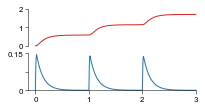

In [111]:
plt.figure(figsize=(3,1.5))
ax=plt.subplot(2,1,1)

plt.plot(t_repeated/24, v_repeated-v_repeated[0], c='C3', clip_on=False, lw=1)
plt.xlim([-0.13, 3])

ax.xaxis.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([0, 2])

ax = plt.subplot(2,1,2)
plt.plot([-0.2, 3], [0,0],c='k', ls='--', lw=0.5)
plt.plot(t_repeated/24, -(w_repeated - w_repeated[0]), clip_on=False, lw=1)
plt.xlim([-0.13, 3])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylim([0, 0.15])
ax.set_yticks([0, 0.075, 0.15])
ax.set_yticklabels([0, '', 0.15]);

# Lyapunov function for Figure 3

In [115]:
ww, vv = np.meshgrid(np.linspace(-0.1, 0.1, 200), np.linspace(0.85, 1.15, 200))

In [132]:
k_v = 8.2715e-5

In [134]:
# Simplified version of heterosynaptic dynamics (Methods, Analysis of synaptic learning dynamics)
def heteroSimple(t, y):

    w = y[0]
    v = y[1]
    
    delta_pc = (w - params['w_i'])*params['mf_0']
    
    dydt = np.zeros(2)
    dydt[0] = 1/params['tau_post'] * (-w + params['w_i'])
    dydt[1] = k_v*(-params['mf_0']*delta_pc)
    return dydt

def heteroSimpleJac(t,y):
    jac = np.array([[-1/params['tau_post'], 0],[-params['mf_0']**2*k_v,0]])
    return jac

In [135]:
T_lyapunov = 23.5
t_lyapunov = np.arange(0, T_lyapunov//0.25, 1)*0.25

trajectories_0 = np.array([[0.9, 0.875],
                         [1.1, 1.025],
                         [0.9, 0.975],
                         [1.1, 1.125],
])

trajectories = np.zeros((4, 2, len(t_lyapunov)))
for i in range(4):
    sol = scipy.integrate.solve_ivp(lambda t,y: heteroSimple(t,y), [0,T_lyapunov],trajectories_0[i,:],
                                          jac=lambda t,y: heteroSimpleJac(t,y),dense_output=True)
    sol_ = sol.sol(t_lyapunov)
    trajectories[i,0,:] = sol_[0,:]-1
    trajectories[i,1,:] = sol_[1,:]

/Users/jbhasin/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:40: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


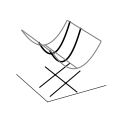

In [138]:
fig = plt.figure(figsize=(1.5, 1.5))
z_offset = -0.002
ax = fig.gca(projection='3d')

plt.plot([0,]*2,[0.85, 1.15],[z_offset, ]*2,'k',lw=1)

ax.plot_wireframe(ww, vv, dw**2+dv**2,color=(0.5,0.5,0.5),cstride=100,rstride=200,
                       linewidth=1)

for i in range(4):
    w_ = trajectories[i,0,:]
    v_ = trajectories[i,1,:]
    dw_ = -1/params['tau_post']*w_
    dv_ = -k_v*(params['mf_0']**2)*w_
    ax.plot(w_, v_, z_offset*np.ones(len(t_lyapunov)), color='k', lw=1)
    ax.plot(w_,v_, dw_**2+dv_**2, color='k')

ax.grid(b=None)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_zticks([]);
ax.set_yticks([]);
ax.set_xticks([]);
ax.w_zaxis.line.set_lw(0.)
zlims = ax.get_zlim();
ax.set_zlim([z_offset, zlims[1]])
ax.set_ylim([0.85, 1.15])
ax.set_xlim([-0.12, 0.12])


ax.view_init(25, 90-30)

plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98);